In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [331]:
train_data=pd.read_csv("dataset/train.csv")

In [332]:
test_data = pd.read_csv("dataset/test.csv")

In [333]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [334]:
train_test_data = [train_data, test_data]

In [335]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    return np.nan

In [336]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }

In [337]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

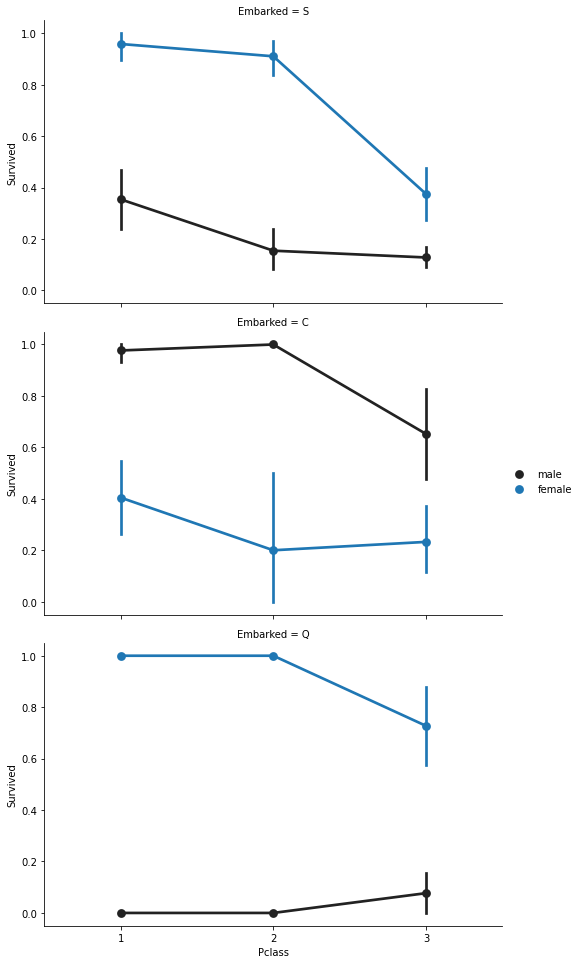

In [338]:
FacetGrid = sns.FacetGrid(train_data, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

In [410]:
def feature_engineering(df):
    #Title
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].map(title_mapping)
    df['Title']=df.apply(replace_titles, axis=1)
    # Family Size
    df['Family_Size']=df['SibSp']+df['Parch']
    
    #Sex Label Encoder
    sex = LabelEncoder()
    df['Sex'] = sex.fit_transform(df['Sex'].astype(str))
    
    #Embarked
    Embarked = LabelEncoder()
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Embarked'] = Embarked.fit_transform(df['Embarked'].astype(str))
    
    #Cabin
    deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    df['Cabin'] = df['Cabin'].fillna("U0")
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    # df['Deck'] = df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    df['Deck'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    df['Deck'] = df['Deck'].map(deck)
    df['Deck'] = df['Deck'].fillna(0)
    df['Deck'] = df['Deck'].astype(int)
    
    df["Age"].fillna(df.groupby("Title")["Age"].transform("median"), inplace=True)
    df["Age"] = df["Age"].astype(int)
    df.loc[df['Age'] <= 11, 'Age'] = 0
    df.loc[(df['Age'] > 11) & (df['Age'] <= 18), 'Age'] = 1
    df.loc[(df['Age'] > 18) & (df['Age'] <= 22), 'Age'] = 2
    df.loc[(df['Age'] > 22) & (df['Age'] <= 27), 'Age'] = 3
    df.loc[(df['Age'] > 27) & (df['Age'] <= 33), 'Age'] = 4
    df.loc[(df['Age'] > 33) & (df['Age'] <= 40), 'Age'] = 5
    df.loc[(df['Age'] > 40) & (df['Age'] <= 66), 'Age'] = 6
    df.loc[ df['Age'] > 66, 'Age'] = 7
    #Age_class
    df['Age_Class']= df['Age']* df['Pclass']
    # Fare 
    df["Fare"].fillna(df.groupby("Pclass")["Fare"].transform("median"), inplace=True)
    df.loc[df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df.loc[(df['Fare'] > 31) & (df['Fare'] <= 99), 'Fare']   = 3
    df.loc[(df['Fare'] > 99) & (df['Fare'] <= 250), 'Fare']   = 4
    df.loc[ df['Fare'] > 250, 'Fare'] = 5
    df['Fare'] = df['Fare'].astype(int)
    df['Fare_Per_Person'] = df['Fare']/(df['Family_Size']+1)
    df['Fare_Per_Person'] = df['Fare_Per_Person'].astype(int)
    return df
                        

In [412]:
train_data=feature_engineering(train_data)
test_data=feature_engineering(test_data)

In [413]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_Size,Deck,Age_Class,Fare_Per_Person
0,1,0,3,"Braund, Mr. Owen Harris",1,0,1,0,A/5 21171,0,U0,2,0,1,8,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0,1,0,PC 17599,0,C85,0,2,1,3,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,0,STON/O2. 3101282,0,U0,2,1,0,8,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0,1,0,113803,0,C123,2,2,1,3,0,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,0,373450,0,U0,2,0,0,8,0,0


In [414]:
y = train_data["Survived"]
features = ["Sex", "Family_Size", "Fare_Per_Person","Embarked","Title","Age_Class","Deck","Fare","Age"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

In [415]:
# PassengerId=test_data["PassengerId"]
# features_drop = ["Ticket","PassengerId","Name","Cabin"]
# train_data = train_data.drop(features_drop, axis=1)
# test_data = test_data.drop(features_drop, axis=1)
# X_train = train_data.drop("Survived", axis=1)
# Y_train = train_data["Survived"]
# X_test  = test_data

In [416]:
X.head()

,Sex,Family_Size,Fare_Per_Person,Embarked,Title,Age_Class,Deck,Fare,Age
0,1,1,0,2,0,0,8,0,0
1,0,1,0,0,2,0,3,0,0
2,0,0,0,2,1,0,8,0,0
3,0,1,0,2,2,0,3,0,0
4,1,0,0,2,0,0,8,0,0


In [417]:
X_test.sample(5)

,Sex,Family_Size,Fare_Per_Person,Embarked,Title,Age_Class,Deck,Fare,Age
155,1,0,0,2,0,0,8,0,0
318,1,0,0,2,0,0,8,0,0
301,1,0,0,0,0,0,4,0,0
205,1,0,0,0,0,0,8,0,0
48,0,0,0,0,2,0,4,0,0


In [418]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [419]:
clf = KNeighborsClassifier(n_neighbors = 13)
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.81111111 0.79775281 0.80898876 0.80898876 0.85393258 0.79775281
 0.82022472 0.85393258 0.82022472 0.83146067]


In [420]:
# kNN Score
round(np.mean(score)*100, 2)

82.04

In [421]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf,X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.83333333 0.82022472 0.78651685 0.75280899 0.82022472 0.78651685
 0.83146067 0.84269663 0.82022472 0.82022472]


In [422]:
round(np.mean(score)*100, 2)

81.14

In [423]:
clf = RandomForestClassifier(n_estimators=103)
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.83333333 0.80898876 0.79775281 0.76404494 0.82022472 0.78651685
 0.83146067 0.83146067 0.80898876 0.87640449]


In [424]:
# Random Forest Score
round(np.mean(score)*100, 2)

81.59

In [425]:
clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)


[0.84444444 0.74157303 0.7752809  0.78651685 0.7752809  0.80898876
 0.79775281 0.84269663 0.83146067 0.83146067]


In [426]:

# Naive Bayes Score
round(np.mean(score)*100, 2)

80.35

In [427]:
clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.81111111 0.76404494 0.83146067 0.80898876 0.83146067 0.80898876
 0.82022472 0.82022472 0.83146067 0.86516854]


In [430]:
round(np.mean(score)*100,2)

81.93

In [431]:
#Testing with SVC
clf.fit(X,y)
predictions = clf.predict(X_test)

In [432]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
